In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

**Exploratory Data Analysis**

In [3]:
df = pd.read_csv('https://richardson.byu.edu/220/OnlineNewsPopularity.csv')
df.head()
df.columns = df.columns.str.strip()
df.columns

Index(['url', 'timedelta', 'n_tokens_title', 'n_tokens_content',
       'n_unique_tokens', 'n_non_stop_words', 'n_non_stop_unique_tokens',
       'num_hrefs', 'num_self_hrefs', 'num_imgs', 'num_videos',
       'average_token_length', 'num_keywords', 'data_channel_is_lifestyle',
       'data_channel_is_entertainment', 'data_channel_is_bus',
       'data_channel_is_socmed', 'data_channel_is_tech',
       'data_channel_is_world', 'kw_min_min', 'kw_max_min', 'kw_avg_min',
       'kw_min_max', 'kw_max_max', 'kw_avg_max', 'kw_min_avg', 'kw_max_avg',
       'kw_avg_avg', 'self_reference_min_shares', 'self_reference_max_shares',
       'self_reference_avg_sharess', 'weekday_is_monday', 'weekday_is_tuesday',
       'weekday_is_wednesday', 'weekday_is_thursday', 'weekday_is_friday',
       'weekday_is_saturday', 'weekday_is_sunday', 'is_weekend', 'LDA_00',
       'LDA_01', 'LDA_02', 'LDA_03', 'LDA_04', 'global_subjectivity',
       'global_sentiment_polarity', 'global_rate_positive_words',
     

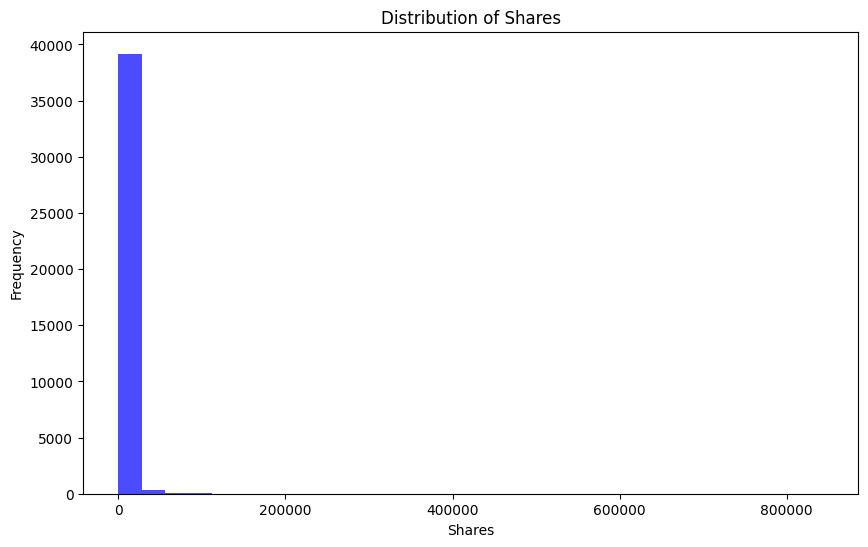

In [5]:
#1 plot the distribution of the target variable
plt.figure(figsize=(10,6))
plt.hist(df['shares'], bins=30, color='blue', alpha=0.7)
plt.title('Distribution of Shares')
plt.xlabel('Shares')
plt.ylabel('Frequency')
plt.show()

Since our histogram is showing the distribution of shares to be heavily skewed to the right, a log transformation on the target variable seems appropriate.

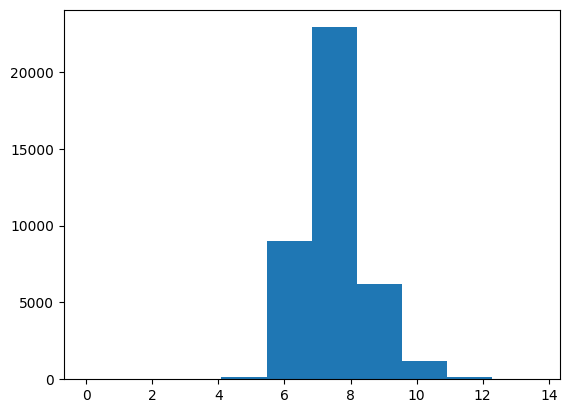

In [6]:
#1 performing a log transformation on the target variable
plt.hist(np.log(df['shares']))
plt.show()

df["log_shares"] = np.log(df['shares'])

In [7]:
#2 build a linear regression model w/o higher order
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


X = df.drop(columns=["shares","log_shares", "url", "timedelta"])

# Dummify
X = pd.get_dummies(X,drop_first = True)
y = df["log_shares"]

# split into train/test groups
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

# Scale the data
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

scale_y = StandardScaler()
scale_y.fit(y_train.values.reshape(-1,1))
y_train_scaled = scale_y.transform(y_train.values.reshape(-1,1))

# Fit a linear regression model
reg_prep = LinearRegression()
mod_reg = reg_prep.fit(X_train_scaled,y_train_scaled)
# print(mod_reg.coef_)


#2 identify the most significant predictors
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'coefficient': mod_reg.coef_.ravel()  # Use ravel() to flatten the array
})

feature_importance['abs_coefficient'] = abs(feature_importance['coefficient'])
top_features = feature_importance.sort_values('abs_coefficient', ascending=False).head(10)

# Display top 10 most significant predictors
print("Top 10 most significant predictors:")
print(top_features[['feature', 'coefficient']])



Top 10 most significant predictors:
                 feature   coefficient
30    weekday_is_tuesday  1.620816e+11
31  weekday_is_wednesday  1.617344e+11
32   weekday_is_thursday  1.611409e+11
29     weekday_is_monday  1.551236e+11
33     weekday_is_friday  1.457750e+11
36            is_weekend  6.314090e+10
35     weekday_is_sunday  5.785749e+10
34   weekday_is_saturday  5.447610e+10
40                LDA_03  5.346878e+01
41                LDA_04  5.244261e+01


In [8]:
#r^2 for the regression model
from sklearn.metrics import mean_squared_error, r2_score
X_test_scaled = scaler.transform(X_test)
preds = scale_y.inverse_transform(mod_reg.predict(X_test_scaled))
print("Out of Sample R^2: ",r2_score(y_test,preds))

in_preds = scale_y.inverse_transform(mod_reg.predict(X_train_scaled))
print("In Sample R^2: ",r2_score(y_train,in_preds))

Out of Sample R^2:  0.11908732172009107
In Sample R^2:  0.1283476368669546


[Text(0.5, 0.9166666666666666, 'kw_avg_avg <= 3085.189\nsquared_error = 0.868\nsamples = 31715\nvalue = 7.474'),
 Text(0.25, 0.75, 'self_reference_avg_sharess <= 1995.75\nsquared_error = 0.674\nsamples = 18796\nvalue = 7.295'),
 Text(0.375, 0.8333333333333333, 'True  '),
 Text(0.125, 0.5833333333333334, 'kw_max_max <= 654150.0\nsquared_error = 0.632\nsamples = 9894\nvalue = 7.17'),
 Text(0.0625, 0.4166666666666667, 'kw_max_avg <= 2960.399\nsquared_error = 0.679\nsamples = 2042\nvalue = 7.389'),
 Text(0.03125, 0.25, 'n_tokens_content <= 158.5\nsquared_error = 0.588\nsamples = 611\nvalue = 7.168'),
 Text(0.015625, 0.08333333333333333, 'squared_error = 0.831\nsamples = 65\nvalue = 7.599'),
 Text(0.046875, 0.08333333333333333, 'squared_error = 0.534\nsamples = 546\nvalue = 7.116'),
 Text(0.09375, 0.25, 'weekday_is_saturday <= 0.5\nsquared_error = 0.688\nsamples = 1431\nvalue = 7.483'),
 Text(0.078125, 0.08333333333333333, 'squared_error = 0.673\nsamples = 1354\nvalue = 7.453'),
 Text(0.109

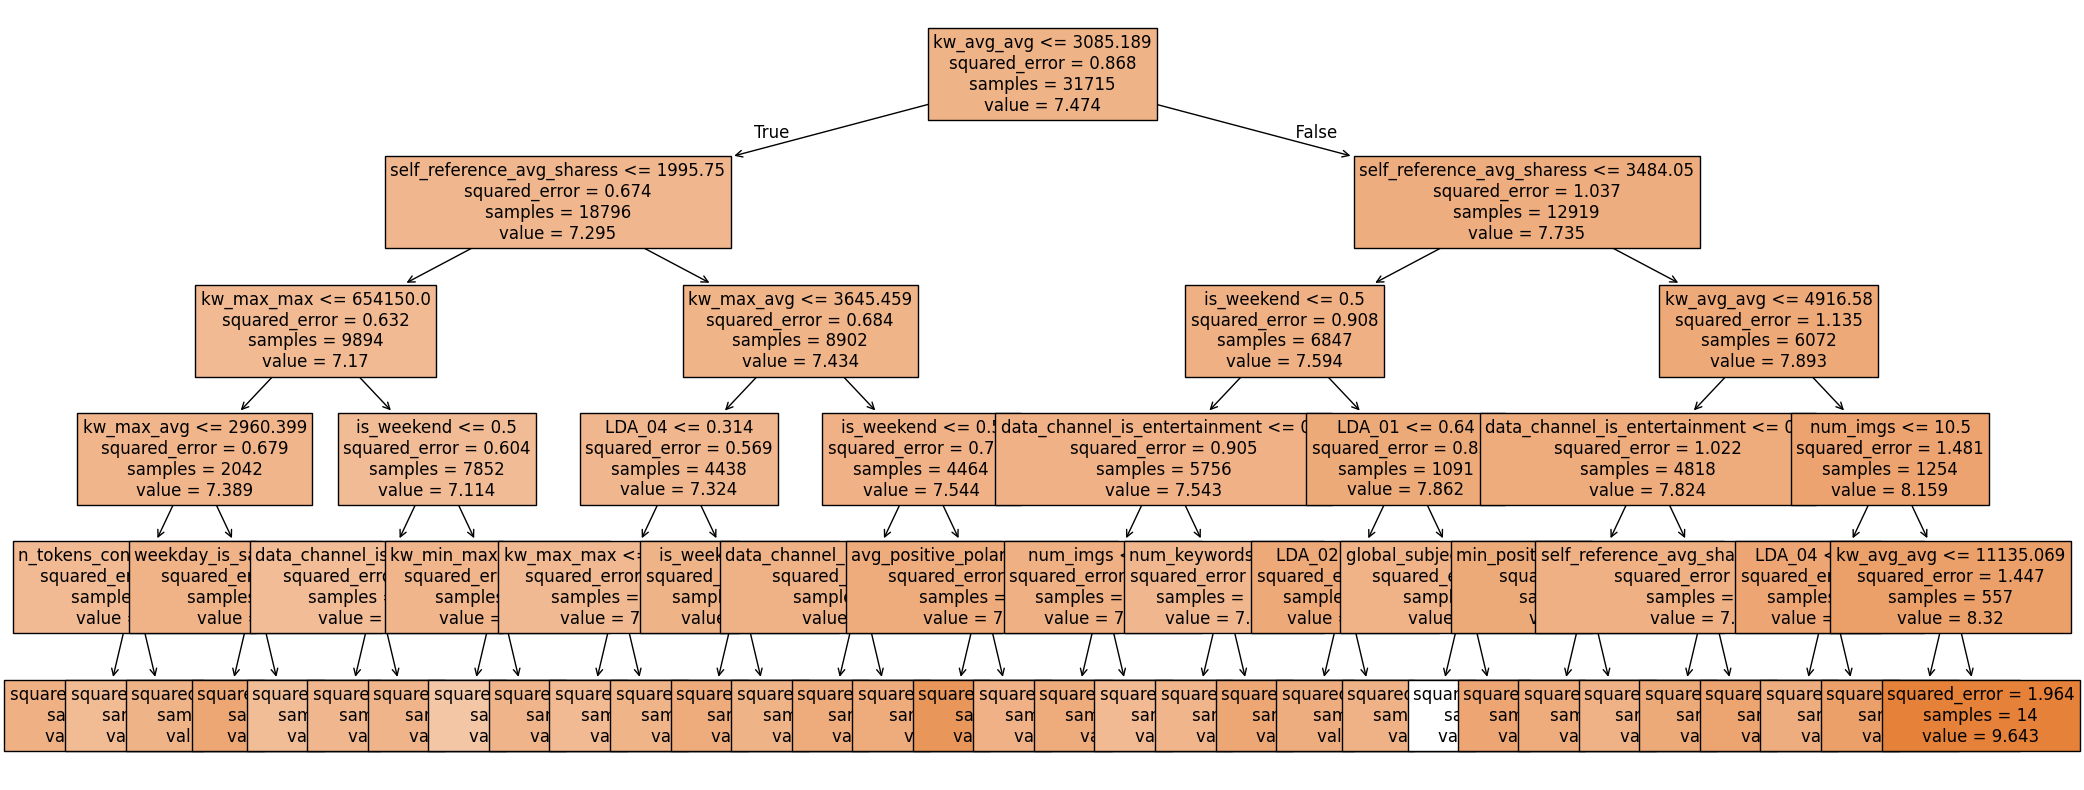

In [19]:
#3 build a regression tree
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor


predictors = df.drop(columns=["shares","log_shares", "url", "timedelta"])

# Dummify
X = pd.get_dummies(predictors,drop_first = True)
y = df["log_shares"]

# split into train/test groups
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

tree_prep = DecisionTreeRegressor(max_depth=5)
mod_tree = tree_prep.fit(X_train,y_train)
plt.figure(figsize = (25,10))
tree.plot_tree(mod_tree, feature_names=X.columns, filled = True,fontsize = 12)

In [ ]:
#compare R squared
preds = mod_tree.predict(X_test)
r2_score(y_test,preds)





0.1040388227222323

<Axes: >

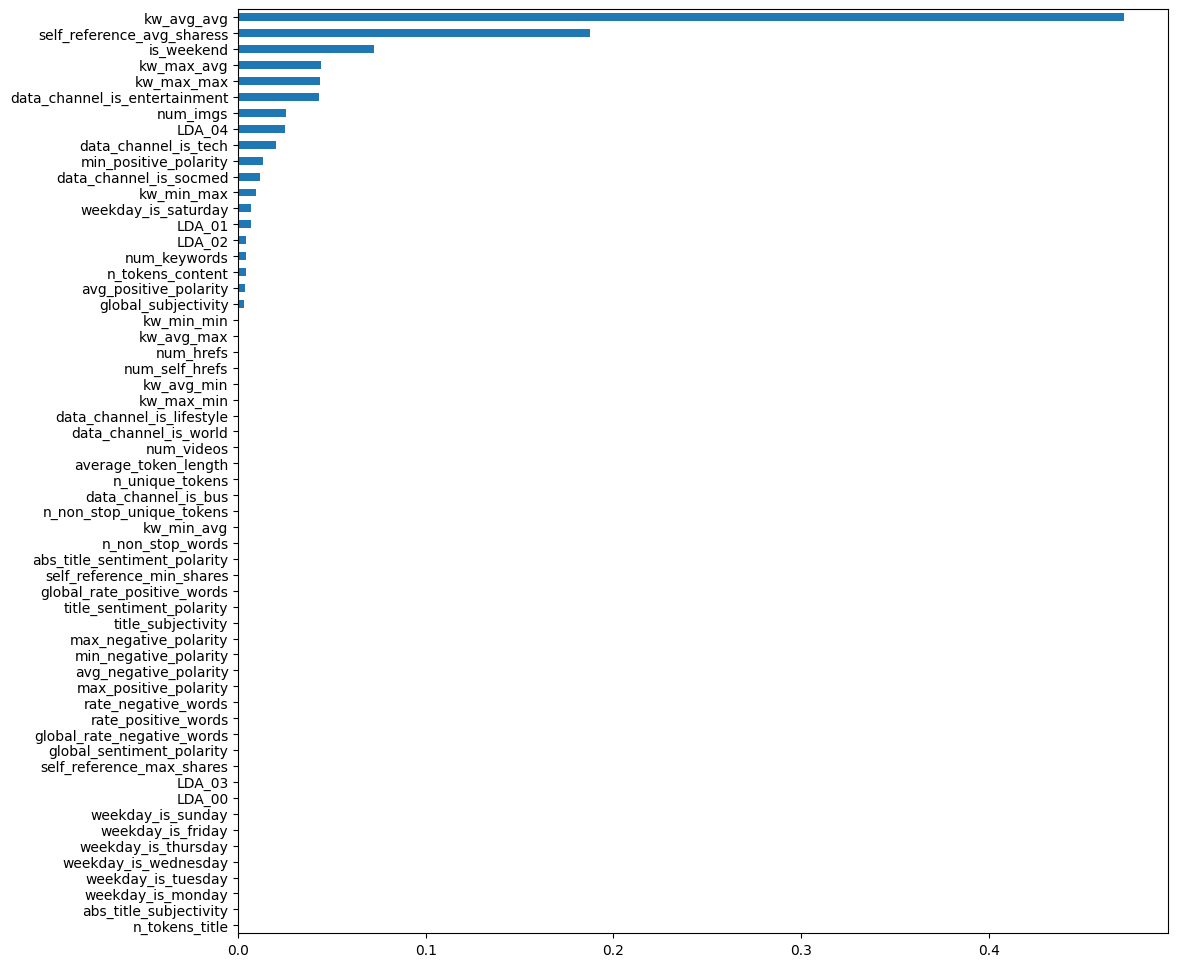

In [24]:
#feature importance for classifcation trees
plt.figure(figsize=(12, 12))
pd.Series(mod_tree.feature_importances_, index=X.columns).sort_values().plot(kind='barh')

In [ ]:
#4 select several significant features from steps 2 & 3 and create visualizations for tables to explore relationship

In [ ]:
#6 use ppropriate methods to remove insignificant variable froms the model.

**Technical Report**